# Tennis Match Predictor (Caden Luu) - 11/4/25

## Summary
This project works with Jeff Sackmann's tennis ATP matches: https://github.com/JeffSackmann/tennis_atp/blob/master/atp_matches_2024.csv
The goal of this project is to predict out of two players, which player has the highest probablity to win based on a number of factors (player ranking, court surface, etc)

## Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Reading in dataset

In [3]:
data_dir = './Data/tennis_atp-master'
all_files = sorted(os.listdir(data_dir))
# Filter for only years 2010-2024
sorted_files = [f for f in all_files if f.startswith('atp_matches_') and 
                any(str(year) in f for year in range(2010, 2025))]
df_2010 = pd.read_csv(data_dir + "/atp_matches_2010.csv")

In [4]:
# For Kaggle
"""
os.listdir('/kaggle/input')
data_dir = '/kaggle/input/atp-matches-2010-to-2024'
sorted_files = sorted(os.listdir(data_dir))
sorted_files, len(sorted_files)
"""


"\nos.listdir('/kaggle/input')\ndata_dir = '/kaggle/input/atp-matches-2010-to-2024'\nsorted_files = sorted(os.listdir(data_dir))\nsorted_files, len(sorted_files)\n"

In [5]:
# For Kaggle
"""
df_2010 = pd.read_csv('/kaggle/input/atp-matches-2010-to-2024/' + sorted_files[0])
df_2010.loc[0]
"""



"\ndf_2010 = pd.read_csv('/kaggle/input/atp-matches-2010-to-2024/' + sorted_files[0])\ndf_2010.loc[0]\n"

In [6]:
df_2010.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2010-339,Brisbane,Hard,32,A,20100103,1,104053,1.0,NaN,Andy Roddick,R,188.0,USA,27.3,103429,NaN,NaN,Peter Luczak,R,183.0,AUS,30.3,7-6(5) 6-2,3,R32,84.0,15.0,0.0,63.0,42.0,36.0,14.0,10.0,3.0,3.0,4.0,2.0,56.0,34.0,29.0,11.0,10.0,3.0,5.0,7.0,4410.0,77.0,598.0
1,2010-339,Brisbane,Hard,32,A,20100103,2,104958,NaN,WC,Carsten Ball,L,198.0,AUS,22.5,104999,NaN,NaN,Mischa Zverev,L,190.0,GER,22.3,7-5 6-1,3,R32,70.0,10.0,3.0,57.0,30.0,23.0,19.0,10.0,0.0,0.0,2.0,2.0,66.0,34.0,22.0,14.0,9.0,7.0,10.0,134.0,400.0,78.0,590.0
2,2010-339,Brisbane,Hard,32,A,20100103,3,104755,NaN,NaN,Richard Gasquet,R,185.0,FRA,23.5,103813,NaN,NaN,Jarkko Nieminen,L,185.0,FIN,28.4,6-3 4-6 6-4,3,R32,121.0,5.0,4.0,97.0,51.0,33.0,27.0,15.0,5.0,8.0,4.0,0.0,85.0,58.0,38.0,14.0,14.0,7.0,11.0,52.0,850.0,88.0,568.0
3,2010-339,Brisbane,Hard,32,A,20100103,4,105051,NaN,Q,Matthew Ebden,R,188.0,AUS,22.1,103781,6.0,NaN,Jurgen Melzer,L,183.0,AUT,28.6,7-5 6-1,3,R32,64.0,12.0,1.0,50.0,35.0,30.0,12.0,10.0,3.0,3.0,2.0,1.0,53.0,29.0,16.0,15.0,9.0,2.0,5.0,285.0,151.0,28.0,1260.0
4,2010-339,Brisbane,Hard,32,A,20100103,5,104607,4.0,NaN,Tomas Berdych,R,196.0,CZE,24.2,105194,NaN,Q,Nick Lindahl,R,183.0,AUS,21.4,6-2 6-4,3,R32,69.0,3.0,1.0,46.0,27.0,24.0,14.0,9.0,1.0,1.0,6.0,1.0,69.0,41.0,26.0,14.0,9.0,6.0,9.0,20.0,1655.0,251.0,179.0


In [7]:
df_2010.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

## The Data

* Tourney ID - unique identifier for tournament
* tourney_name - name of tournament (e.g. "Wimbledon", "US Open" , etc)
* surface - type of court surface
* draw_size - number of players in main draw
* tourney_level - Category of event ('G' for Grand Slam, 'M' for Masters 1000, 'A' For ATP 250/500
* tourney_date - Date tournament started
* math_num - sequential match number within the tournament
* round - which round match was played in 'R128', 'SF' semi-final, etc
* best_of - # of sets required to win
* minutes - duration of match in minutes
* score - final score
* winner_id / loser_id - unique player ID for the winner/loser
* winner_seed / loser_seed - seed number for winner/loser
* winner_entry / loser_entry - how player was entered ('Q' for qualifier, 'WC', for wildcard, 'LL' for lucky loser
* winner_name / loser_name - winner's name
* winner_hand / loser_hand - Dominant hand
* winner_ht / loser_ht - height of player in centimeters
* winner_ioc / loser_ioc - Country code of player
* winner_age / loser_age - winner/loser age
* winner_rank / loser_rank - ATP ranking of winner/loser at time of match
* winner_rank_points / loser_rank_points - ATP ranking points of the winner/loser of that time
* w_ace / l_ace - number of aces hit by winner/loser
* w_df / l_df - double faults by winner/loser
* w_svpt / l_svpt - total service points played
* w_1stIn / l_1stIn - first serves that went in
* w_1stWon / l_1stWon - points on on first serve
* w_2ndWon / l_2ndWon - points won on second serve
* w_SVGms / l_SvGms - service games played
* w_bpSaved / l_bpSaved - break points saved
* w_bpFaced / l_bpFaced - break points faced

### Combining dataframes

In [8]:
dfs_by_year = {}

for f in sorted_files:
    year = int(f.split('_')[-1].split('.')[0])
    if 2010 <= year <= 2024:
        dfs_by_year[year] = pd.read_csv(os.path.join(data_dir, f))

## Exploratory Data Analysis (EDA)

In [9]:
dfs_by_year[2010].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6597 entries, 0 to 6596
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          6597 non-null   object 
 1   tourney_name        6597 non-null   object 
 2   surface             6597 non-null   object 
 3   draw_size           6597 non-null   int64  
 4   tourney_level       6597 non-null   object 
 5   tourney_date        6597 non-null   int64  
 6   match_num           6597 non-null   int64  
 7   winner_id           6597 non-null   int64  
 8   winner_seed         2855 non-null   float64
 9   winner_entry        726 non-null    object 
 10  winner_name         6597 non-null   object 
 11  winner_hand         6597 non-null   object 
 12  winner_ht           6151 non-null   float64
 13  winner_ioc          6597 non-null   object 
 14  winner_age          6597 non-null   float64
 15  loser_id            6597 non-null   int64  
 16  loser_

In [10]:
dfs_by_year[2010].describe()

,draw_size,tourney_date,match_num,winner_id,winner_seed,winner_ht,winner_age,loser_id,loser_seed,loser_ht,loser_age,best_of,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
count,6597.000000,6.597000e+03,6597.000000,6597.000000,2855.000000,6151.000000,6597.000000,6597.000000,1566.000000,5477.000000,6592.000000,6597.000000,6498.000000,6498.000000,6498.000000,6498.000000,6498.000000,6498.000000,6498.000000,6498.000000,6498.000000,6498.000000,6498.000000,6498.000000,6498.000000,6498.000000,6498.000000,6498.000000,6498.000000,6498.000000,6498.000000,6552.000000,6552.000000,6382.000000,6382.000000
mean,39.713809,2.010065e+07,213.875246,104494.770047,5.240981,184.291010,25.469789,104625.562680,5.683269,184.233157,25.121769,3.004851,95.302093,4.971068,2.402893,69.091105,43.187442,31.909357,14.317482,11.008618,3.252231,4.798553,3.704986,3.229301,71.807941,43.564789,28.086180,12.651277,10.853647,4.433364,8.227762,223.076923,304.737485,306.067064,230.481510
std,25.111044,2.976977e+02,317.208229,771.869176,4.498937,6.482887,3.608498,1032.780077,4.601910,6.314662,3.935230,0.098384,32.685991,4.232481,2.097193,22.504206,15.072671,10.075516,5.698089,3.003449,2.857004,3.738804,3.670294,2.358847,22.010297,15.241563,11.416525,5.863432,3.025718,3.028256,3.618291,157.226904,196.962515,249.020224,168.421717
min,28.000000,2.010010e+07,1.000000,101404.000000,1.000000,168.000000,16.700000,101404.000000,1.000000,168.000000,15.000000,3.000000,9.000000,0.000000,0.000000,4.000000,3.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,17.000000,1.000000,17.000000,1.000000
25%,32.000000,2.010041e+07,11.000000,104003.000000,2.000000,180.000000,22.700000,104035.000000,3.000000,180.000000,22.300000,3.000000,71.000000,2.000000,1.000000,52.000000,32.000000,25.000000,10.000000,9.000000,1.000000,2.000000,1.000000,2.000000,56.000000,32.000000,20.000000,8.000000,9.000000,2.000000,6.000000,128.000000,170.000000,164.000000,117.000000
50%,32.000000,2.010070e+07,22.000000,104505.000000,4.000000,183.000000,25.300000,104593.000000,5.000000,183.000000,24.900000,3.000000,89.000000,4.000000,2.000000,65.000000,41.000000,30.000000,14.000000,10.000000,3.000000,4.000000,3.000000,3.000000,68.000000,41.000000,27.000000,12.000000,10.000000,4.000000,8.000000,186.500000,259.000000,234.000000,199.000000
75%,32.000000,2.010091e+07,703.000000,105015.000000,7.000000,188.000000,28.000000,105099.000000,7.000000,188.000000,27.800000,3.000000,117.000000,7.000000,3.000000,85.000000,53.000000,38.000000,18.000000,13.000000,5.000000,7.000000,5.000000,4.000000,86.000000,53.000000,35.000000,16.000000,13.000000,6.000000,10.000000,266.000000,419.000000,342.000000,300.750000
max,128.000000,2.010112e+07,812.000000,110572.000000,32.000000,203.000000,42.900000,110739.000000,33.000000,203.000000,43.100000,5.000000,240.000000,38.000000,18.000000,191.000000,128.000000,101.000000,43.000000,32.000000,18.000000,25.000000,31.000000,20.000000,189.000000,137.000000,102.000000,38.000000,32.000000,20.000000,27.000000,1601.000000,1985.000000,1791.000000,1985.000000


### Converting tourney date to datetime

In [11]:
for i in np.arange(2010,2025):
    dfs_by_year[i]['tournament_date'] = pd.to_datetime(dfs_by_year[i]['tourney_date'], format = '%Y%m%d')
    dfs_by_year[i] = dfs_by_year[i].drop('tourney_date', axis = 1)
dfs_by_year[2010].head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tournament_date
0,2010-1536,Madrid Masters,Clay,56,M,701,103428,1.0,NaN,Juan Ignacio Chela,R,190.0,ARG,30.6,104477,NaN,NaN,Jorge Aguilar,R,178.0,CHI,25.3,6-4 6-4,3,Q1,92.0,1.0,1.0,51.0,32.0,27.0,11.0,10.0,2.0,4.0,2.0,1.0,62.0,37.0,23.0,10.0,10.0,4.0,8.0,51.0,839.0,226.0,205.0,2010-05-09
1,2010-1536,Madrid Masters,Clay,56,M,702,104262,NaN,NaN,Flavio Cipolla,R,173.0,ITA,26.5,104592,13.0,NaN,Ilija Bozoljac,R,193.0,SRB,24.7,7-5 6-2,3,Q1,93.0,1.0,3.0,67.0,53.0,36.0,8.0,10.0,3.0,4.0,4.0,2.0,78.0,46.0,30.0,10.0,10.0,11.0,15.0,263.0,171.0,129.0,405.0,2010-05-09
2,2010-1536,Madrid Masters,Clay,56,M,703,104739,NaN,NaN,Guillermo Alcaide,R,188.0,ESP,23.9,104516,NaN,NaN,Arnau Brugues Davi,L,183.0,ESP,25.1,7-5 7-5,3,Q1,99.0,11.0,1.0,79.0,52.0,43.0,9.0,12.0,5.0,7.0,2.0,2.0,79.0,47.0,34.0,10.0,12.0,4.0,8.0,228.0,205.0,227.0,205.0,2010-05-09
3,2010-1536,Madrid Masters,Clay,56,M,704,103926,NaN,WC,Daniel Munoz de la Nava,L,178.0,ESP,28.2,105154,14.0,NaN,Joao Souza,R,193.0,BRA,21.9,6-4 6-4,3,Q1,90.0,4.0,2.0,55.0,39.0,29.0,10.0,10.0,3.0,4.0,5.0,3.0,76.0,45.0,27.0,15.0,10.0,5.0,8.0,315.0,134.0,127.0,409.0,2010-05-09
4,2010-1536,Madrid Masters,Clay,56,M,705,105053,3.0,NaN,Santiago Giraldo,R,188.0,COL,22.4,105098,NaN,NaN,Alexandre Sidorenko,R,185.0,FRA,22.2,6-1 6-2,3,Q1,68.0,4.0,0.0,44.0,29.0,20.0,11.0,7.0,1.0,1.0,1.0,1.0,61.0,33.0,20.0,7.0,8.0,7.0,12.0,59.0,764.0,245.0,192.0,2010-05-09


### Checking for missing values

In [12]:
for i in np.arange(2010,2025):
    missing = dfs_by_year[i].isnull().sum()
    show_missing = missing[missing > 0]
    print(f"\n{i}'s' Missing values:")
    if show_missing.empty:
        print('No missing values')
    else:
        print(show_missing)
    


2010's' Missing values:
winner_seed           3742
winner_entry          5871
winner_ht              446
loser_seed            5031
loser_entry           5110
loser_ht              1120
loser_age                5
minutes                 99
w_ace                   99
w_df                    99
w_svpt                  99
w_1stIn                 99
w_1stWon                99
w_2ndWon                99
w_SvGms                 99
w_bpSaved               99
w_bpFaced               99
l_ace                   99
l_df                    99
l_svpt                  99
l_1stIn                 99
l_1stWon                99
l_2ndWon                99
l_SvGms                 99
l_bpSaved               99
l_bpFaced               99
winner_rank             45
winner_rank_points      45
loser_rank             215
loser_rank_points      215
dtype: int64

2011's' Missing values:
winner_seed           3480
winner_entry          5665
winner_ht              445
loser_seed            4874
loser_entry        

### Filling in missing *winner_seed*, *winner_entry*, *loser_seed*, *loser_entry* with "Unknown"

In [13]:
for i in np.arange(2010, 2025):
    dfs_by_year[i]['winner_seed'].fillna("Unknown", inplace= True)
    dfs_by_year[i]['winner_entry'].fillna('Unknown', inplace = True)
    dfs_by_year[i]['loser_seed'].fillna('Unknown', inplace = True)
    dfs_by_year[i]['loser_entry'].fillna('Unknown', inplace = True)
    

### Filling in missing *winner_ht*, *loser_ht*, *winner_age*, *loser_age* with mean of column

In [14]:
columns = ['winner_ht', 'winner_age', 'loser_ht', 'loser_age']
for i in np.arange(2010,2011):
    for column in columns:
        print(f"\n Year {i}: \n")
        print(dfs_by_year[i][column].describe(include = all))


 Year 2010: 

count    6151.000000
mean      184.291010
std         6.482887
min       168.000000
25%       180.000000
50%       183.000000
75%       188.000000
max       203.000000
Name: winner_ht, dtype: float64

 Year 2010: 

count    6597.000000
mean       25.469789
std         3.608498
min        16.700000
25%        22.700000
50%        25.300000
75%        28.000000
max        42.900000
Name: winner_age, dtype: float64

 Year 2010: 

count    5477.000000
mean      184.233157
std         6.314662
min       168.000000
25%       180.000000
50%       183.000000
75%       188.000000
max       203.000000
Name: loser_ht, dtype: float64

 Year 2010: 

count    6592.000000
mean       25.121769
std         3.935230
min        15.000000
25%        22.300000
50%        24.900000
75%        27.800000
max        43.100000
Name: loser_age, dtype: float64


In [15]:
# Mean and Median of variables are relatively similar so imputing with mean is fine
for i in np.arange(2010,2025):
    dfs_by_year[i]['winner_ht'].fillna(dfs_by_year[i]['winner_ht'].mean(), inplace = True)
    dfs_by_year[i]['winner_age'].fillna(dfs_by_year[i]['winner_age'].mean(), inplace = True)
    dfs_by_year[i]['loser_ht'].fillna(dfs_by_year[i]['loser_ht'].mean(), inplace = True)
    dfs_by_year[i]['loser_age'].fillna(dfs_by_year[i]['loser_age'].mean(), inplace = True)

### Filling in missing *minutes* values with median of column

In [16]:
for i in np.arange(2010,2015):
    print(f"\nYear: {i}")
    print(dfs_by_year[i].groupby('best_of')['minutes'].agg('mean', 'median', 'count'))


Year: 2010
best_of
3     95.181888
5    144.000000
Name: minutes, dtype: float64

Year: 2011
best_of
3     96.497034
5    197.437500
Name: minutes, dtype: float64

Year: 2012
best_of
3     96.720864
5    160.562500
Name: minutes, dtype: float64

Year: 2013
best_of
3     91.355077
5    135.266667
Name: minutes, dtype: float64

Year: 2014
best_of
3     91.823954
5    145.250000
Name: minutes, dtype: float64


In [17]:
for i in np.arange(2010,2025):
    dfs_by_year[i]['minutes'] = dfs_by_year[i].groupby('best_of')['minutes'].transform(lambda x: x.fillna(x.median()))

### Dealing with serve-related stat columns

In [18]:
# All serve columns for each year are missing same amount of values,
# meaning most likely that the corresponding rows are missing all values in these columns
serve_cols = [
    'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
    'w_SvGms', 'w_bpSaved', 'w_bpFaced',
    'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon',
    'l_SvGms', 'l_bpSaved', 'l_bpFaced', 
]
for i in np.arange(2010,2025):
    dfs_by_year[i] = dfs_by_year[i].dropna(subset = serve_cols, how = 'any')

In [19]:
for i in np.arange(2010,2025):
    missing = dfs_by_year[i].isnull().sum()
    show_missing = missing[missing > 0]
    print(f"\n{i}'s' Missing values:")
    if show_missing.empty:
        print('No missing values')
    else:
        print(show_missing)
    


2010's' Missing values:
winner_rank            44
winner_rank_points     44
loser_rank            214
loser_rank_points     214
dtype: int64

2011's' Missing values:
winner_rank            32
winner_rank_points     32
loser_rank            215
loser_rank_points     215
dtype: int64

2012's' Missing values:
winner_rank            38
winner_rank_points     38
loser_rank            221
loser_rank_points     221
dtype: int64

2013's' Missing values:
winner_rank            39
winner_rank_points     39
loser_rank            179
loser_rank_points     179
dtype: int64

2014's' Missing values:
winner_rank            39
winner_rank_points     39
loser_rank            182
loser_rank_points     182
dtype: int64

2015's' Missing values:
winner_rank           12
winner_rank_points    12
loser_rank            89
loser_rank_points     89
dtype: int64

2016's' Missing values:
loser_hand              6
winner_rank           198
winner_rank_points    198
loser_rank            774
loser_rank_points     7

### Dropping missing *winner_rank*, *winner_rank_points*, *loser_rank*, *loser_rank_points*

In [20]:
drop_columns = ['winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points']
for i in np.arange(2010,2025):
    dfs_by_year[i] = dfs_by_year[i].dropna(subset = drop_columns)

In [21]:
for i in np.arange(2010,2025):
    missing = dfs_by_year[i].isnull().sum()
    show_missing = missing[missing > 0]
    print(f"\n{i}'s' Missing values:")
    if show_missing.empty:
        print('No missing values')
    else:
        print(show_missing)
    


2010's' Missing values:
No missing values

2011's' Missing values:
No missing values

2012's' Missing values:
No missing values

2013's' Missing values:
No missing values

2014's' Missing values:
No missing values

2015's' Missing values:
No missing values

2016's' Missing values:
No missing values

2017's' Missing values:
No missing values

2018's' Missing values:
No missing values

2019's' Missing values:
No missing values

2020's' Missing values:
No missing values

2021's' Missing values:
No missing values

2022's' Missing values:
No missing values

2023's' Missing values:
No missing values

2024's' Missing values:
No missing values


### Visualizations

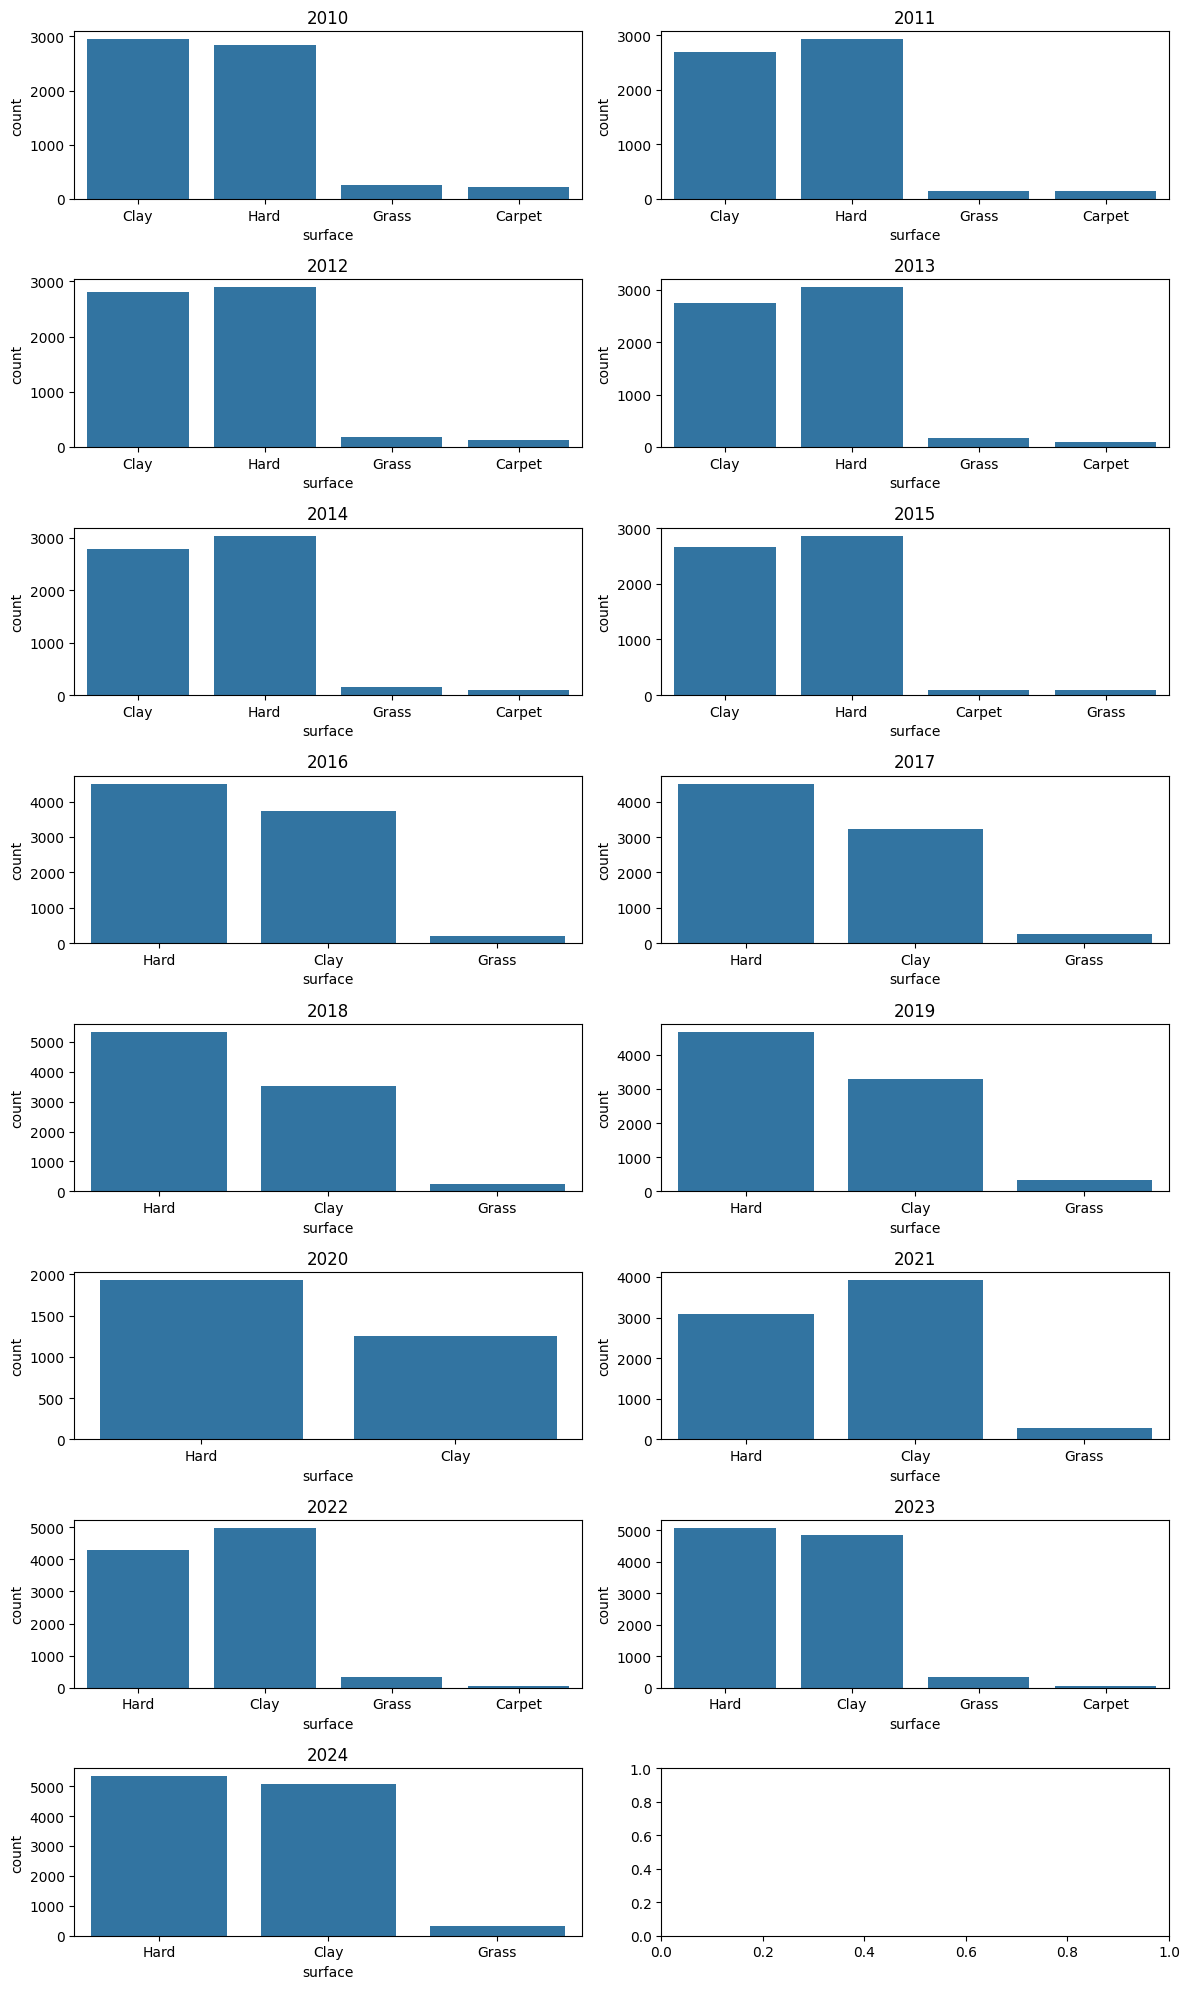

In [22]:
fig, axes = plt.subplots(nrows = 8, ncols = 2, figsize = (12,20))
axes = axes.flatten()
for idx,i in enumerate(np.arange(2010,2025)):
    sns.countplot(x = 'surface', data = dfs_by_year[i], ax=axes[idx])
    axes[idx].set_title(f"{i}")

plt.tight_layout()
plt.show()




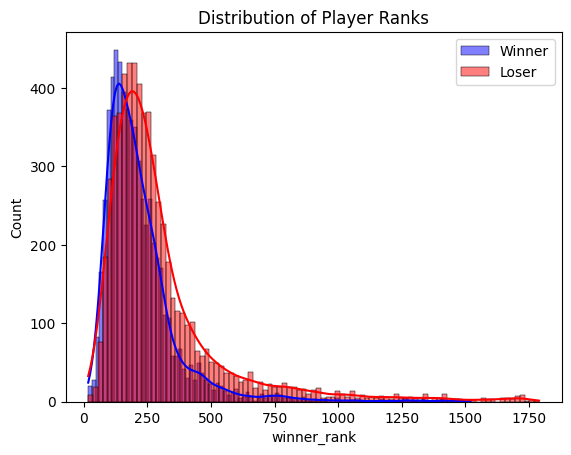

In [23]:
sns.histplot(dfs_by_year[2010]['winner_rank'], color = 'blue', label = 'Winner', kde = True)
sns.histplot(dfs_by_year[2010]['loser_rank'], color = 'red', label = "Loser", kde = True)
plt.title("Distribution of Player Ranks")
plt.legend()

Text(0.5, 1.0, 'Winner Rank Vs # of Aces')

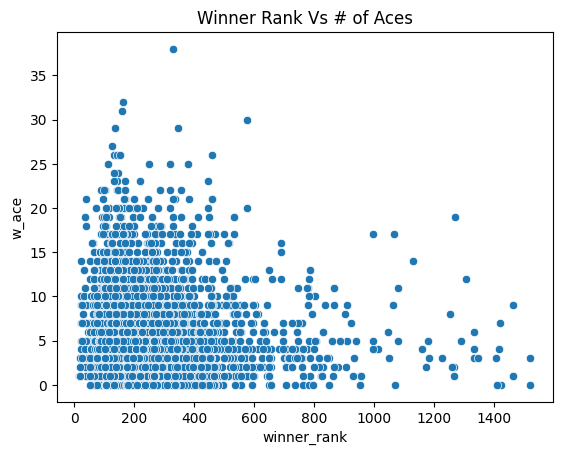

In [24]:
sns.scatterplot(x='winner_rank', y='w_ace', data = dfs_by_year[2010])
plt.title('Winner Rank Vs # of Aces')

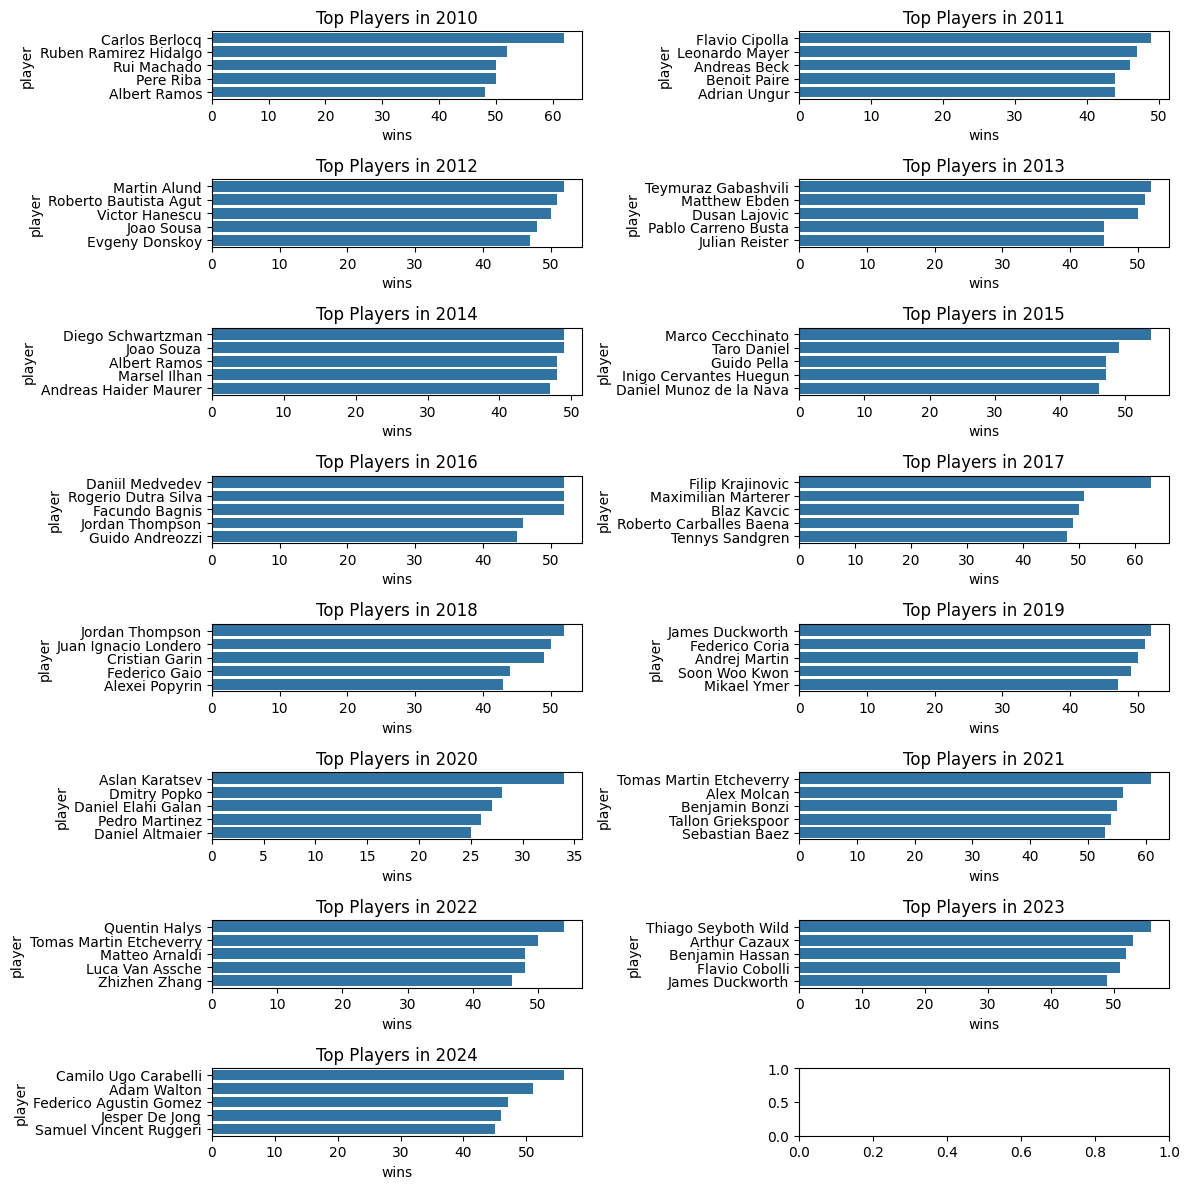

In [25]:
fig, axes = plt.subplots(nrows = 8, ncols = 2, figsize = (12,12))
axes = axes.flatten()
for idx, i in enumerate(np.arange(2010,2025)):
    total_wins = dfs_by_year[i]['winner_name'].value_counts()
    wins_df = total_wins.reset_index()
    wins_df.columns = ['player', 'wins']
    top5 = wins_df.head(5)
    axes[idx].set_title(f"Top Players in {i}")
    sns.barplot(x='wins', y= 'player', data = top5, ax=axes[idx], orient = 'h')
plt.tight_layout()
plt.show()





## Feature Engineering

Creating new variables to help the model better predict who will win
* Rank Difference (*winner_rank* - *loser_rank*)
* Break point conversion (*winner_bp_faced* - *winner_bp_saved*/ *winner_bp_faced*)
* Age difference (*winner_rank* - *loser_rank*)
* Rank Point Difference (*winner_rank_points* - *loser_rank_points*)

In [26]:
# Creating new variable *rank_difference*
for i in np.arange(2010,2025):
    dfs_by_year[i]['rank_difference'] = dfs_by_year[i]['winner_rank'] - dfs_by_year[i]['loser_rank']
# Creating new variable *l_bpConv* 
for i in np.arange(2010,2025):
    dfs_by_year[i]['l_bpConv'] = (dfs_by_year[i]['w_bpFaced']-dfs_by_year[i]['w_bpSaved'])/dfs_by_year[i]['w_bpFaced'].replace(0,1)
# Creating new variable *w_bpConv*
for i in np.arange(2010,2025):
    dfs_by_year[i]['w_bpConv'] =(dfs_by_year[i]['l_bpFaced']-dfs_by_year[i]['l_bpSaved'])/dfs_by_year[i]['l_bpFaced'].replace(0,1)
# Creating new variable *age_difference*
for i in np.arange(2010,2025):
    dfs_by_year[i]['age_difference'] = dfs_by_year[i]['winner_age'] - dfs_by_year[i]['loser_age']
# Creating new variable *point_difference*
for i in np.arange(2010,2025):
    dfs_by_year[i]['rank_point_difference'] = dfs_by_year[i]['winner_rank_points'] - dfs_by_year[i]['loser_rank_points']

### Data is in a format (winner and loser stats in same row) that is not usable for predicting winner

* Currently, *w_* and *l_* stats leak the match outcome, so we have to aggregate the stats by per-player average rather than per-match average

### Merging winner/loser rows into separate winner row & loser row DataFrame

In [27]:
all_player_dfs = []  # Store each year's data

for i in np.arange(2010, 2025):
    df = dfs_by_year[i]  # Get one year
    
    winner_cols = [col for col in df.columns if col.startswith('w_')]
    loser_cols = [col for col in df.columns if col.startswith('l_')]
    
    # Winner DataFrame
    winner_df = df[winner_cols].copy()
    winner_df.columns = [col.replace('w_', 'player_') for col in winner_cols]
    winner_df['player'] = df['winner_name']
    winner_df['opponent'] = df['loser_name']
    winner_df['is_winner'] = 1
    
    # Loser DataFrame
    loser_df = df[loser_cols].copy()
    loser_df.columns = [col.replace('l_', 'player_') for col in loser_cols]
    loser_df['player'] = df['loser_name']
    loser_df['opponent'] = df['winner_name']
    loser_df['is_winner'] = 0
    
    shared_cols = ['surface', "best_of", "round", "tourney_name",
                   "rank_difference", "age_difference", "rank_point_difference",
                   "minutes", "score"]
    winner_df[shared_cols] = df[shared_cols].values
    loser_df[shared_cols] = df[shared_cols].values
    
    # Combine winner and loser for this year
    year_player_df = pd.concat([winner_df, loser_df], ignore_index=True)
    all_player_dfs.append(year_player_df)

# Combine ALL years
player_df = pd.concat(all_player_dfs, ignore_index=True)

# Move is_winner to end
cols = player_df.columns.tolist()
cols.remove('is_winner')
cols.append('is_winner')
player_df = player_df[cols]

print(f"Total rows: {len(player_df)}")
player_df.head()

Total rows: 221964


,player_ace,player_df,player_svpt,player_1stIn,player_1stWon,player_2ndWon,player_SvGms,player_bpSaved,player_bpFaced,player_bpConv,player,opponent,surface,best_of,round,tourney_name,rank_difference,age_difference,rank_point_difference,minutes,score,is_winner
0,1.0,1.0,51.0,32.0,27.0,11.0,10.0,2.0,4.0,0.500000,Juan Ignacio Chela,Jorge Aguilar,Clay,3,Q1,Madrid Masters,-175.0,5.3,634.0,92.0,6-4 6-4,1
1,1.0,3.0,67.0,53.0,36.0,8.0,10.0,3.0,4.0,0.266667,Flavio Cipolla,Ilija Bozoljac,Clay,3,Q1,Madrid Masters,134.0,1.8,-234.0,93.0,7-5 6-2,1
2,11.0,1.0,79.0,52.0,43.0,9.0,12.0,5.0,7.0,0.500000,Guillermo Alcaide,Arnau Brugues Davi,Clay,3,Q1,Madrid Masters,1.0,-1.2,0.0,99.0,7-5 7-5,1
3,4.0,2.0,55.0,39.0,29.0,10.0,10.0,3.0,4.0,0.375000,Daniel Munoz de la Nava,Joao Souza,Clay,3,Q1,Madrid Masters,188.0,6.3,-275.0,90.0,6-4 6-4,1
4,4.0,0.0,44.0,29.0,20.0,11.0,7.0,1.0,1.0,0.416667,Santiago Giraldo,Alexandre Sidorenko,Clay,3,Q1,Madrid Masters,-186.0,0.2,572.0,68.0,6-1 6-2,1


### Dropping unnecessary columns

In [28]:
# Drop *score* column
player_df = player_df.drop(columns = ['score','minutes','tourney_name', 'player', 'opponent'])
player_df.columns

Index(['player_ace', 'player_df', 'player_svpt', 'player_1stIn',
       'player_1stWon', 'player_2ndWon', 'player_SvGms', 'player_bpSaved',
       'player_bpFaced', 'player_bpConv', 'surface', 'best_of', 'round',
       'rank_difference', 'age_difference', 'rank_point_difference',
       'is_winner'],
      dtype='object')

### Convert *best_of* to numeric feature

In [29]:
player_df['best_of'] = player_df['best_of'].astype(int)

### One Hot Encode

In [30]:
# One-Hot Encode surface
player_df = pd.get_dummies(player_df, columns=['surface'], drop_first=False)

### Ordinal Encode

In [31]:
# Ordinal Encode *round*
from sklearn.preprocessing import OrdinalEncoder

round_order = [[
    'Q1','Q2','Q3',
    'R128', 'R64','R32','R16',
    'QF','SF','F'
]]

encoder = OrdinalEncoder(categories=round_order)

player_df['round_encoded'] = encoder.fit_transform(player_df[['round']])

# Drop original *round* variable
player_df = player_df.drop(columns=['round'])

# Move target variable to end
cols = player_df.columns.tolist()
cols.remove('is_winner')
cols.append('is_winner')
player_df = player_df[cols]



In [32]:
player_df

,player_ace,player_df,player_svpt,player_1stIn,player_1stWon,player_2ndWon,player_SvGms,player_bpSaved,player_bpFaced,player_bpConv,best_of,rank_difference,age_difference,rank_point_difference,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,round_encoded,is_winner
0,1.0,1.0,51.0,32.0,27.0,11.0,10.0,2.0,4.0,0.500000,3,-175.0,5.3,634.0,False,True,False,False,0.0,1
1,1.0,3.0,67.0,53.0,36.0,8.0,10.0,3.0,4.0,0.266667,3,134.0,1.8,-234.0,False,True,False,False,0.0,1
2,11.0,1.0,79.0,52.0,43.0,9.0,12.0,5.0,7.0,0.500000,3,1.0,-1.2,0.0,False,True,False,False,0.0,1
3,4.0,2.0,55.0,39.0,29.0,10.0,10.0,3.0,4.0,0.375000,3,188.0,6.3,-275.0,False,True,False,False,0.0,1
4,4.0,0.0,44.0,29.0,20.0,11.0,7.0,1.0,1.0,0.416667,3,-186.0,0.2,572.0,False,True,False,False,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221959,2.0,6.0,78.0,45.0,32.0,11.0,11.0,3.0,6.0,0.166667,3,-239.0,-3.6,45.0,False,False,False,True,0.0,0
221960,0.0,0.0,73.0,54.0,29.0,9.0,10.0,5.0,9.0,0.400000,3,-664.0,5.0,102.0,False,False,False,True,0.0,0
221961,0.0,1.0,54.0,31.0,16.0,10.0,8.0,4.0,8.0,0.000000,3,-353.0,-1.9,54.0,False,False,False,True,0.0,0
221962,0.0,5.0,66.0,41.0,22.0,8.0,10.0,4.0,10.0,0.375000,3,-279.0,-2.3,60.0,False,False,False,True,0.0,0


In [33]:
numeric_cols = player_df.select_dtypes(include = ['int64', 'float64']).columns
categorical_cols = player_df.select_dtypes(include = ['category', 'object']).columns

numeric_data = player_df[numeric_cols]
categorical_data = player_df[categorical_cols]
player_df = pd.concat([numeric_data, categorical_data],axis = 1)
player_df.columns

cols = player_df.columns.tolist()
cols.remove('is_winner')
cols.append('is_winner')
player_df = player_df[cols]

### Splitting Data Into Training and Testing sets

In [34]:
X = player_df.iloc[:, :-1].values
y = player_df.iloc[:, -1].values

In [35]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size = 0.2, 
                                                 random_state = 42)


### Feature Scaling

In [36]:
# Feature Scale Numeric Columns
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_fs = X_train.copy()
X_test_fs = X_test.copy()

X_train_fs[:, :13] = sc.fit_transform(X_train_fs[:, :13])
X_test_fs[:, :13] = sc.transform(X_test_fs[:, :13])



## Build Models
* Logistic Regression
* Random Forest Classifier
* XGBClassifier
* Neural Network

### Identify key features to help predict
* Use *surface*, *tourney_level*, *winner_ht*, *winner_ioc*, *winner_age*, *winner_hand* *loser_ht*, *loser_ioc*, *loser_hand*, *rank_difference*, *point_rank_difference*

### Baseline Logistic Regression Model

In [37]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = 42, max_iter = 1000)
lr.fit(X_train_fs, y_train)
lr_pred = lr.predict(X_test_fs)

### Random Forest Classifier

In [38]:
n_estimators = [50,100,150,200]
max_features = ['auto', 'sqrt','log2']
max_depth = [100,200,None]
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
bootstrap = [True,False]

param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
# Use RandomizedSearchCV to find best parameters for RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
rfc_random_grid = RandomizedSearchCV(estimator = rfc,
                                   param_distributions = param_grid,
                                   cv = 3,
                                   verbose = 2,
                                   n_iter = 5,
                                   n_jobs = -1)
rfc_random_grid.fit(X_train, y_train) #Decision Tree based models don't require feature scaling

# Outputting best parameters and saving those parameters
print("Best parameters: ", rfc_random_grid.best_params_)
best_rfc_params = rfc_random_grid.best_params_

best_rfc_model = RandomForestClassifier(**best_rfc_params)
best_rfc_model.fit(X_train,y_train)
rfc_pred = best_rfc_model.predict(X_test)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}


### Neural Network

In [48]:
import torch
from torch import nn

In [49]:
# Turn data into tensor type
X_nn = torch.tensor(X.astype(np.float64), dtype=torch.float32)
y_nn = torch.tensor(y.astype(np.float64), dtype=torch.float32)

# Split into training and testing set
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn,y_nn,
                                                                test_size = 0.2, random_state = 42)
# Feature Scale
X_scaled = sc.fit_transform(X_nn)

X_nn = torch.tensor(X_scaled, dtype=torch.float32)
y_nn = torch.tensor(y.astype(np.float64), dtype = torch.float32)


In [50]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(15,64)
        self.layer_2 = nn.Linear(64,32)
        self.layer_3 = nn.Linear(32,16)
        self.layer_4 = nn.Linear(16,1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))
model_0 = BinaryClassifier()

In [51]:
# Set up loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr = 0.01)

In [52]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

torch.manual_seed(42)
epochs = 1000

for epoch in tqdm(range(epochs)):
    model_0.train()
    # Forward Pass
    y_logits = model_0(X_train_nn).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Loss
    loss = loss_fn(y_logits,y_train_nn)
    acc = accuracy_score(y_train_nn.detach().numpy(),y_pred.detach().numpy())

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()
    
    # Testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test_nn).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test_nn)
        test_acc = accuracy_score(y_test_nn.numpy(), test_pred.numpy())

    if(epoch % 100 == 0):
        print(f"Epoch: {epoch} | Loss: {loss.item():.2f} | Acc: {acc * 100:.2f}% | Test Loss: {test_loss.item():.2f} | Test Acc: {test_acc * 100:.2f}%")



  0%|          | 3/1000 [00:00<01:41,  9.84it/s]

Epoch: 0 | Loss: 1.29 | Acc: 50.03% | Test Loss: 1.00 | Test Acc: 49.77%


 10%|█         | 103/1000 [00:09<00:53, 16.65it/s]

Epoch: 100 | Loss: 0.69 | Acc: 56.33% | Test Loss: 0.69 | Test Acc: 52.86%


 20%|██        | 205/1000 [00:14<00:44, 17.86it/s]

Epoch: 200 | Loss: 0.68 | Acc: 59.40% | Test Loss: 0.68 | Test Acc: 55.53%


 30%|███       | 303/1000 [00:19<00:35, 19.65it/s]

Epoch: 300 | Loss: 0.66 | Acc: 59.56% | Test Loss: 0.69 | Test Acc: 55.80%


 40%|████      | 404/1000 [00:25<00:30, 19.59it/s]

Epoch: 400 | Loss: 0.64 | Acc: 62.61% | Test Loss: 0.69 | Test Acc: 56.65%


 50%|█████     | 504/1000 [00:30<00:24, 19.90it/s]

Epoch: 500 | Loss: 0.60 | Acc: 69.18% | Test Loss: 0.63 | Test Acc: 63.80%


 60%|██████    | 604/1000 [00:35<00:19, 20.64it/s]

Epoch: 600 | Loss: 0.66 | Acc: 62.16% | Test Loss: 0.78 | Test Acc: 57.05%


 70%|███████   | 703/1000 [00:40<00:15, 19.53it/s]

Epoch: 700 | Loss: 0.60 | Acc: 72.54% | Test Loss: 0.60 | Test Acc: 72.16%


 80%|████████  | 805/1000 [00:45<00:10, 19.06it/s]

Epoch: 800 | Loss: 0.58 | Acc: 72.58% | Test Loss: 0.57 | Test Acc: 71.75%


 90%|█████████ | 905/1000 [00:51<00:04, 21.32it/s]

Epoch: 900 | Loss: 0.59 | Acc: 69.75% | Test Loss: 0.58 | Test Acc: 73.75%


100%|██████████| 1000/1000 [00:55<00:00, 17.87it/s]


In [56]:
# Neural Network Predictions
model_0.eval()
with torch.inference_mode():
    nn_preds = torch.round(torch.sigmoid(model_0(X_test_nn))).squeeze()

### Accuracy Score of RandomForestClassifier and Logistic Regression

In [57]:
from sklearn.metrics import accuracy_score
model_predictions = {
    'Logistic Regression': lr_pred,
    'Random Forest Classifier': rfc_pred,
    'Neural Network Classifier': nn_preds
}
for model_name, predictions in model_predictions.items():
    acc_score = accuracy_score(y_test,predictions)
    print(f"{model_name} accuracy: {acc_score*100:.2f}%")

Logistic Regression accuracy: 84.25%
Random Forest Classifier accuracy: 87.21%
Neural Network Classifier accuracy: 71.60%
